# Telco Customer Churn — Modeling & Evaluation

**Objective:** Train and evaluate churn models (Logistic Regression and KNN), then select a decision threshold aligned to a retention use case.

**Inputs**
- `data/processed/telco_churn_clean.csv` from Notebook 1

**Outputs**
- Saved model pipeline to `models/`
- Evaluation figures + a recommended threshold


In [5]:
from pathlib import Path
import shutil

# Notebook 2 expects the processed dataset created by Notebook 1:
#    data/processed/telco_churn_clean.csv
PROCESSED_PATH = Path("data/processed/telco_churn_clean.csv")
PROCESSED_PATH.parent.mkdir(parents=True, exist_ok=True)

try:
    from google.colab import files  # type: ignore

    # If the processed file isn't present yet, prompt for upload
    if not PROCESSED_PATH.exists():
        print("📤 Please upload telco_churn_clean.csv (output from Notebook 1).")
        uploaded = files.upload()

        # Prefer the exact expected filename, otherwise fall back to first uploaded CSV
        if "telco_churn_clean.csv" in uploaded:
            uploaded_name = "telco_churn_clean.csv"
        else:
            csvs = [k for k in uploaded.keys() if k.lower().endswith(".csv")]
            if not csvs:
                raise FileNotFoundError("No .csv file was uploaded. Please upload telco_churn_clean.csv.")
            uploaded_name = csvs[0]

        src = Path("/content") / uploaded_name
        shutil.move(str(src), str(PROCESSED_PATH))

    print(f" Found processed dataset at: {PROCESSED_PATH.resolve()}")
except Exception as e:
    # If not in Colab, or upload didn't happen, just explain what to do.
    if PROCESSED_PATH.exists():
        print(f" Found processed dataset at: {PROCESSED_PATH.resolve()}")
    else:
        print("ℹ If you're NOT running in Colab, place the processed dataset at:")
        print(f"   {PROCESSED_PATH}")
        print("   (Then re-run this notebook.)")
        print(f"Details: {e}")


 Found processed dataset at: /content/data/processed/telco_churn_clean.csv


## 0) Setup

In [6]:

import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier

from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
    f1_score,
    precision_score,
    recall_score,
)

import joblib

np.random.seed(42)
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)

DATA_PATH = Path("data/processed/telco_churn_clean.csv")
MODELS_DIR = Path("models")
MODELS_DIR.mkdir(parents=True, exist_ok=True)

print("CWD:", Path.cwd())
print("Data path:", DATA_PATH.resolve())
print("Models dir:", MODELS_DIR.resolve())


CWD: /content
Data path: /content/data/processed/telco_churn_clean.csv
Models dir: /content/models


## 1) Load processed data

In [7]:
import pandas as pd

if not DATA_PATH.exists():
    raise FileNotFoundError(
        f"Could not find {DATA_PATH}.\n"
        "In Colab: run the upload cell at the top of this notebook and upload telco_churn_clean.csv.\n"
        "That file should be saved to data/processed/telco_churn_clean.csv."
    )

df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
df.head()


Shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 2) Split features/target and train/test split

In [9]:
TARGET = "Churn"
X = df.drop(columns=[TARGET])
y = df[TARGET].map({'Yes': 1, 'No': 0})

# 80/20 train-test split (test set held out until the very end)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Split training set into train/validation for threshold selection (prevents test-set leakage)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.25, stratify=y_train, random_state=42
)  # 0.25 of 0.80 = 0.20 of total => 60/20/20 overall

print("Train (tr) shape:", X_tr.shape, "Validation shape:", X_val.shape, "Test shape:", X_test.shape)
print("Churn rates — tr:", y_tr.mean(), "val:", y_val.mean(), "test:", y_test.mean())

Train (tr) shape: (4225, 20) Validation shape: (1409, 20) Test shape: (1409, 20)
Churn rates — tr: 0.26532544378698225 val: 0.2654364797728886 test: 0.2654364797728886


## 3) Preprocessing pipeline

In [10]:

# Identify column types
numeric_features = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X_train.select_dtypes(exclude=["int64", "float64"]).columns.tolist()

print("Numeric features:", numeric_features)
print("Categorical features (first 10):", categorical_features[:10], "…", len(categorical_features))

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


Numeric features: ['SeniorCitizen', 'tenure', 'MonthlyCharges']
Categorical features (first 10): ['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection'] … 17


## 4) Baseline model

In [11]:

baseline = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", DummyClassifier(strategy="most_frequent")),
    ]
)

baseline.fit(X_train, y_train)
y_pred_base = baseline.predict(X_test)
y_proba_base = baseline.predict_proba(X_test)[:, 1]

print("Baseline ROC-AUC:", roc_auc_score(y_test, y_proba_base))
print(classification_report(y_test, y_pred_base, digits=3))


Baseline ROC-AUC: 0.5
              precision    recall  f1-score   support

           0      0.735     1.000     0.847      1035
           1      0.000     0.000     0.000       374

    accuracy                          0.735      1409
   macro avg      0.367     0.500     0.423      1409
weighted avg      0.540     0.735     0.622      1409



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 5) Logistic Regression (with tuning)

In [12]:
log_reg = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", LogisticRegression(max_iter=2000, solver="liblinear")),
    ]
)

param_grid_lr = {
    "model__C": [0.01, 0.1, 1.0, 10.0],
    "model__penalty": ["l1", "l2"],
}

grid_lr = GridSearchCV(
    log_reg,
    param_grid=param_grid_lr,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1,
)

# Hyperparameter tuning on TRAIN-ONLY (X_tr)
grid_lr.fit(X_tr, y_tr)
print("Best LR params:", grid_lr.best_params_)
print("Best CV ROC-AUC (on X_tr):", grid_lr.best_score_)

# Model trained on X_tr (GridSearchCV refits the best estimator on X_tr by default)
best_lr = grid_lr.best_estimator_

# Validation probabilities (used ONLY to choose threshold)
y_proba_lr_val = best_lr.predict_proba(X_val)[:, 1]

# Refit final LR on full training data (X_train = X_tr + X_val) BEFORE evaluating on test
best_lr.fit(X_train, y_train)

# Test probabilities + default-threshold evaluation (0.50)
y_proba_lr = best_lr.predict_proba(X_test)[:, 1]
y_pred_lr = (y_proba_lr >= 0.5).astype(int)

print("Test ROC-AUC (LogReg):", roc_auc_score(y_test, y_proba_lr))
print(classification_report(y_test, y_pred_lr, digits=3))


Best LR params: {'model__C': 1.0, 'model__penalty': 'l2'}
Best CV ROC-AUC (on X_tr): 0.8478696199455318
Test ROC-AUC (LogReg): 0.8403446226975638
              precision    recall  f1-score   support

           0      0.843     0.886     0.864      1035
           1      0.632     0.543     0.584       374

    accuracy                          0.795      1409
   macro avg      0.738     0.714     0.724      1409
weighted avg      0.787     0.795     0.790      1409



## 6) KNN (with tuning)

In [13]:
knn = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", KNeighborsClassifier()),
    ]
)

param_grid_knn = {
    "model__n_neighbors": [3, 5, 7, 11, 15, 21],
    "model__weights": ["uniform", "distance"],
}

grid_knn = GridSearchCV(
    knn,
    param_grid=param_grid_knn,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1,
)

# Hyperparameter tuning on TRAIN-ONLY (X_tr)
grid_knn.fit(X_tr, y_tr)
print("Best KNN params:", grid_knn.best_params_)
print("Best CV ROC-AUC (on X_tr):", grid_knn.best_score_)

best_knn = grid_knn.best_estimator_

# Refit final KNN on full training data BEFORE evaluating on test
best_knn.fit(X_train, y_train)

y_proba_knn = best_knn.predict_proba(X_test)[:, 1]
y_pred_knn = (y_proba_knn >= 0.5).astype(int)

print("Test ROC-AUC (KNN):", roc_auc_score(y_test, y_proba_knn))
print(classification_report(y_test, y_pred_knn, digits=3))


Best KNN params: {'model__n_neighbors': 21, 'model__weights': 'uniform'}
Best CV ROC-AUC (on X_tr): 0.831930559265938
Test ROC-AUC (KNN): 0.8243470510733938
              precision    recall  f1-score   support

           0      0.851     0.854     0.852      1035
           1      0.592     0.586     0.589       374

    accuracy                          0.783      1409
   macro avg      0.721     0.720     0.721      1409
weighted avg      0.782     0.783     0.782      1409



## 7) Visual evaluation (ROC + Precision–Recall)

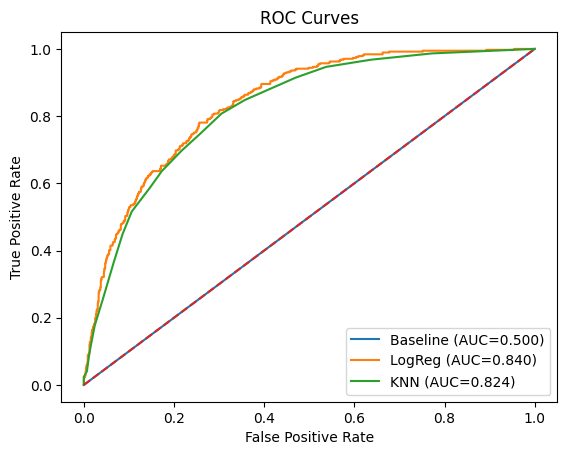

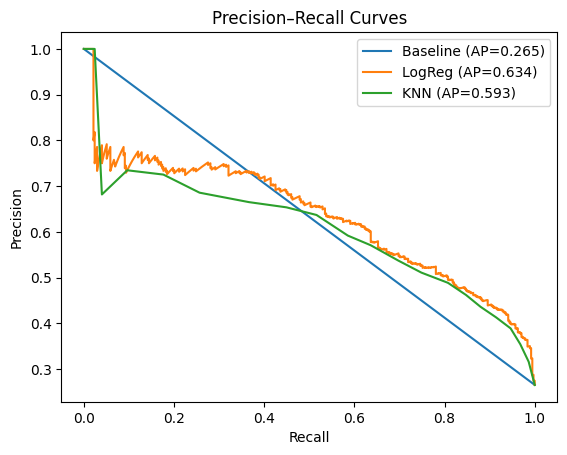

In [14]:

def plot_roc(y_true, proba, label):
    fpr, tpr, _ = roc_curve(y_true, proba)
    auc = roc_auc_score(y_true, proba)
    plt.plot(fpr, tpr, label=f"{label} (AUC={auc:.3f})")

plt.figure()
plot_roc(y_test, y_proba_base, "Baseline")
plot_roc(y_test, y_proba_lr, "LogReg")
plot_roc(y_test, y_proba_knn, "KNN")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()

def plot_pr(y_true, proba, label):
    precision, recall, _ = precision_recall_curve(y_true, proba)
    ap = average_precision_score(y_true, proba)
    plt.plot(recall, precision, label=f"{label} (AP={ap:.3f})")

plt.figure()
plot_pr(y_test, y_proba_base, "Baseline")
plot_pr(y_test, y_proba_lr, "LogReg")
plot_pr(y_test, y_proba_knn, "KNN")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves")
plt.legend()
plt.show()


## 8) Threshold selection (turn probabilities into decisions)

In [15]:
def threshold_table(y_true, proba, thresholds):
    rows = []
    for t in thresholds:
        pred = (proba >= t).astype(int)
        rows.append({
            "threshold": t,
            "precision": precision_score(y_true, pred, zero_division=0),
            "recall": recall_score(y_true, pred, zero_division=0),
            "f1": f1_score(y_true, pred, zero_division=0),
            "positive_rate": float(pred.mean()),  # % flagged for outreach
        })
    return pd.DataFrame(rows)

thresholds = np.round(np.linspace(0.1, 0.9, 17), 2)

# Choose threshold on VALIDATION set (prevents test-set leakage)
tbl_lr_val = threshold_table(y_val, y_proba_lr_val, thresholds)
display(tbl_lr_val.sort_values("f1", ascending=False).head(10))

best_row = tbl_lr_val.sort_values("f1", ascending=False).iloc[0]
best_threshold = float(best_row["threshold"])
print("Chosen threshold (LogReg, max F1 on VALIDATION):", best_threshold)
best_row


,threshold,precision,recall,f1,positive_rate
5,0.35,0.590805,0.687166,0.635352,0.308730
4,0.30,0.543137,0.740642,0.626697,0.361959
3,0.25,0.508651,0.786096,0.617647,0.410220
6,0.40,0.605670,0.628342,0.616798,0.275373
7,0.45,0.635838,0.588235,0.611111,0.245564
2,0.20,0.478395,0.828877,0.606654,0.459901
8,0.50,0.673540,0.524064,0.589474,0.206529
1,0.15,0.437584,0.871658,0.582663,0.528744
9,0.55,0.694981,0.481283,0.568720,0.183818
0,0.10,0.397451,0.917112,0.554568,0.612491


Chosen threshold (LogReg, max F1 on VALIDATION): 0.35


,5
threshold,0.350000
precision,0.590805
recall,0.687166
f1,0.635352
positive_rate,0.308730


## 9) Final evaluation on test set (threshold chosen on validation)

Now we **freeze** the chosen threshold (picked using validation labels only) and evaluate exactly once on the **held-out test set**.


Final model: Logistic Regression
Threshold (chosen on validation): 0.35
ROC-AUC (test): 0.8403446226975638
              precision    recall  f1-score   support

           0      0.878     0.796     0.835      1035
           1      0.552     0.695     0.615       374

    accuracy                          0.769      1409
   macro avg      0.715     0.746     0.725      1409
weighted avg      0.792     0.769     0.777      1409



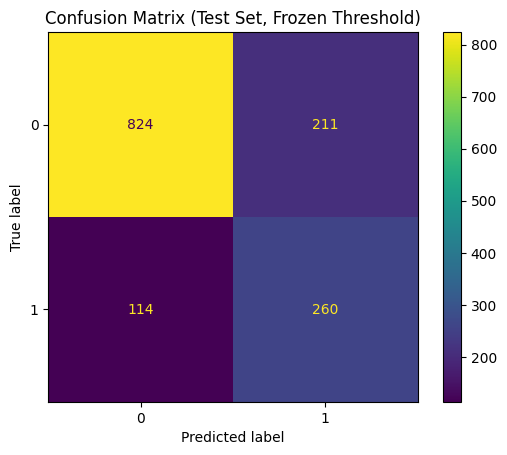

In [16]:
final_pred = (y_proba_lr >= best_threshold).astype(int)

print("Final model: Logistic Regression")
print("Threshold (chosen on validation):", best_threshold)
print("ROC-AUC (test):", roc_auc_score(y_test, y_proba_lr))
print(classification_report(y_test, final_pred, digits=3))

cm = confusion_matrix(y_test, final_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix (Test Set, Frozen Threshold)")
plt.show()


## 10) Interpret Logistic Regression coefficients (top drivers)

,feature,coef
6955,TotalCharges_20.15,1.282946
6864,TotalCharges_19.9,1.280052
6962,TotalCharges_20.5,1.216888
6954,TotalCharges_20.1,1.020873
7648,TotalCharges_288.05,0.976295
6858,TotalCharges_19.6,0.970289
6855,TotalCharges_19.45,0.962730
5759,TotalCharges_1052.35,0.960786
328,customerID_0607-DAAHE,0.960786
10284,TotalCharges_740.3,0.958090


,feature,coef
10761,TotalCharges_89.25,-0.577480
8567,TotalCharges_422.4,-0.584178
3607,customerID_6350-XFYGW,-0.584178
2789,customerID_4929-XIHVW,-0.599174
6171,TotalCharges_134.05,-0.600082
5648,InternetService_DSL,-0.627436
8672,TotalCharges_44,-0.633090
2777,customerID_4912-PIGUY,-0.638310
4217,customerID_7439-DKZTW,-0.638470
7985,TotalCharges_335.75,-0.647081


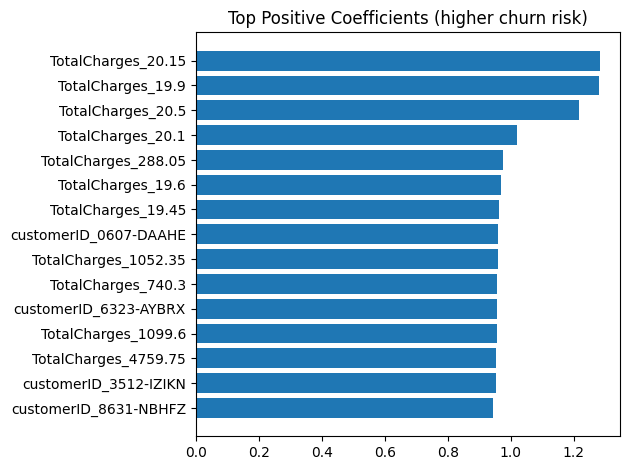

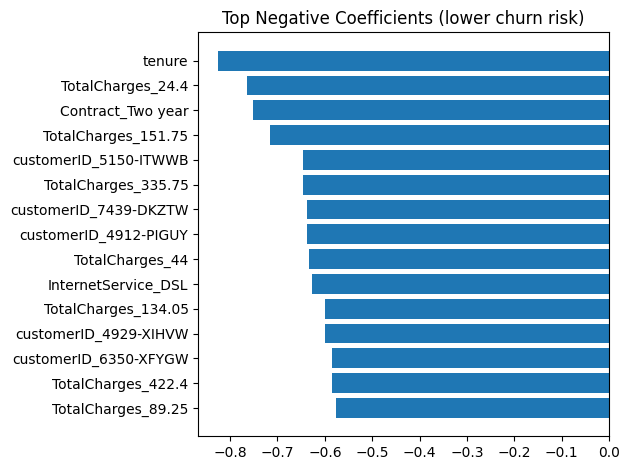

In [17]:

# Extract feature names after one-hot encoding
ohe = best_lr.named_steps["preprocess"].named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = ohe.get_feature_names_out(categorical_features)
feature_names = np.concatenate([numeric_features, cat_feature_names])

coef = best_lr.named_steps["model"].coef_.ravel()
coef_df = pd.DataFrame({"feature": feature_names, "coef": coef}).sort_values("coef", ascending=False)

display(coef_df.head(15))
display(coef_df.tail(15))

# Optional: plot top +/- coefficients
top_pos = coef_df.head(15).sort_values("coef")
top_neg = coef_df.tail(15)

plt.figure()
plt.barh(top_pos["feature"], top_pos["coef"])
plt.title("Top Positive Coefficients (higher churn risk)")
plt.tight_layout()
plt.show()

plt.figure()
plt.barh(top_neg["feature"], top_neg["coef"])
plt.title("Top Negative Coefficients (lower churn risk)")
plt.tight_layout()
plt.show()


## 12) Next-level evaluation
This section adds (a) cost/capacity-based thresholding, (b) probability calibration, (c) subgroup performance checks, and (d) permutation importance for a more stable interpretation view.

In [18]:
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve
from sklearn.inspection import permutation_importance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Build a convenient test dataframe for subgroup analysis
df_test = X_test.copy()
df_test["_y_true"] = y_test.values
df_test["_proba"] = y_proba_lr

print("Test set size:", df_test.shape[0])
print("Test churn rate:", df_test["_y_true"].mean())

Test set size: 1409
Test churn rate: 0.2654364797728886


### 12.1 Capacity-based thresholding
Instead of optimizing F1, a business may have a fixed outreach capacity (e.g., contact the top 10% highest-risk customers). We can choose a threshold that flags the top X% by predicted risk **using the validation probabilities** and then evaluate that frozen rule on the test set.

In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def threshold_for_top_pct(proba: np.ndarray, top_pct: float) -> float:
    """Return threshold that flags approximately top_pct of cases by probability."""
    if not (0 < top_pct < 1):
        raise ValueError("top_pct must be between 0 and 1.")
    return float(np.quantile(proba, 1 - top_pct))

def eval_at_threshold(y_true, proba, thr: float):
    pred = (proba >= thr).astype(int)
    return {
        "threshold": thr,
        "positive_rate": float(pred.mean()),
        "accuracy": accuracy_score(y_true, pred),
        "precision": precision_score(y_true, pred, zero_division=0),
        "recall": recall_score(y_true, pred, zero_division=0),
        "f1": f1_score(y_true, pred, zero_division=0),
    }

capacity_levels = [0.05, 0.10, 0.15, 0.20, 0.30]
rows = []
for pct in capacity_levels:
    thr = threshold_for_top_pct(y_proba_lr_val, pct)  # choose on VALIDATION
    out = eval_at_threshold(y_test, y_proba_lr, thr)  # evaluate on TEST
    out["top_pct_targeted"] = pct
    rows.append(out)

capacity_table = pd.DataFrame(rows).sort_values("top_pct_targeted")
display(capacity_table)

,threshold,positive_rate,accuracy,precision,recall,f1,top_pct_targeted
0,0.734366,0.053229,0.762243,0.760000,0.152406,0.253898,0.05
1,0.662328,0.106458,0.785664,0.740000,0.296791,0.423664,0.10
2,0.595841,0.155429,0.799148,0.707763,0.414439,0.522766,0.15
3,0.517039,0.210078,0.799858,0.655405,0.518717,0.579104,0.20
4,0.359850,0.325763,0.769340,0.553377,0.679144,0.609844,0.30


### 12.2 Probability calibration
We compute the **Brier score** (lower is better) and plot a reliability curve. Calibration matters when probabilities are used for budgeting or expected-value decisions.

Brier score (LogReg, test): 0.13875


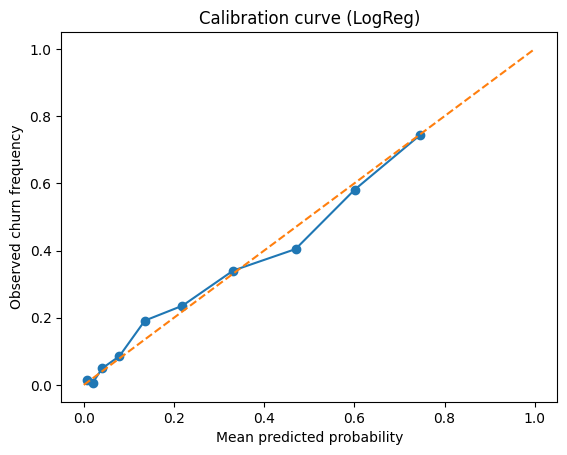

In [20]:
# Brier score on test set
brier = brier_score_loss(y_test, y_proba_lr)
print("Brier score (LogReg, test):", round(brier, 5))

# Reliability curve
prob_true, prob_pred = calibration_curve(y_test, y_proba_lr, n_bins=10, strategy="quantile")

plt.figure()
plt.plot(prob_pred, prob_true, marker="o")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("Mean predicted probability")
plt.ylabel("Observed churn frequency")
plt.title("Calibration curve (LogReg)")
plt.show()

### 12.3 Subgroup performance checks
To ensure the model performs reasonably across key business segments, we report precision/recall/F1 by subgroup at the **final chosen threshold**.

In [21]:
def subgroup_metrics(df_sub: pd.DataFrame, group_col: str, thr: float):
    out_rows = []
    for g, d in df_sub.groupby(group_col):
        y_true = d["_y_true"].values
        proba = d["_proba"].values
        pred = (proba >= thr).astype(int)
        out_rows.append({
            group_col: g,
            "n": int(d.shape[0]),
            "churn_rate": float(y_true.mean()),
            "precision": precision_score(y_true, pred, zero_division=0),
            "recall": recall_score(y_true, pred, zero_division=0),
            "f1": f1_score(y_true, pred, zero_division=0),
        })
    return pd.DataFrame(out_rows).sort_values("n", ascending=False)

print("Final threshold used (chosen on validation):", best_threshold)

# By contract type (common churn driver)
if "Contract" in df_test.columns:
    display(subgroup_metrics(df_test, "Contract", best_threshold))

# By tenure bucket (if present in processed data)
if "tenure_bucket" in df_test.columns:
    display(subgroup_metrics(df_test, "tenure_bucket", best_threshold))

Final threshold used (chosen on validation): 0.35


,Contract,n,churn_rate,precision,recall,f1
0,Month-to-month,773,0.425614,0.554113,0.778116,0.647282
2,Two year,336,0.026786,0.000000,0.000000,0.000000
1,One year,300,0.120000,0.444444,0.111111,0.177778


### 12.4 Permutation importance (stable feature importance)
Because billing variables like `MonthlyCharges`, `TotalCharges`, and `tenure` are correlated, raw coefficients can be unstable. Permutation importance provides a more robust view of which original input features matter most for ROC-AUC in the fitted pipeline.

In [22]:
# Permutation importance on the full pipeline, permuting ORIGINAL columns (not one-hot columns)
perm = permutation_importance(
    best_lr,
    X_test,
    y_test,
    n_repeats=10,
    random_state=42,
    scoring="roc_auc",
)

pi = pd.DataFrame({
    "feature": X_test.columns,
    "importance_mean": perm.importances_mean,
    "importance_std": perm.importances_std,
}).sort_values("importance_mean", ascending=False)

display(pi.head(20))

,feature,importance_mean,importance_std
5,tenure,0.082578,0.003705
15,Contract,0.030436,0.003726
8,InternetService,0.028295,0.006981
18,MonthlyCharges,0.010144,0.002806
9,OnlineSecurity,0.003850,0.001307
12,TechSupport,0.003265,0.001042
17,PaymentMethod,0.003229,0.001504
16,PaperlessBilling,0.002646,0.001353
14,StreamingMovies,0.002624,0.001541
7,MultipleLines,0.002283,0.001275


## 13) Save the final model pipeline

In [23]:

model_path = MODELS_DIR / "logreg_churn_pipeline.joblib"
joblib.dump({"model": best_lr, "threshold": best_threshold}, model_path)
print("Saved:", model_path)


Saved: models/logreg_churn_pipeline.joblib
